In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors

L = 15
df = pd.read_csv("../../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")
df["geno_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("geno_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'



mutation_names = ['G339D','S371L','S373P','S375F',
                  'K417N',
                  'N440K',
                  'G446S',
                  'S477N','T478K',
                  'E484A',
                  'Q493R',
                  'G496S',
                  'Q498R','N501Y','Y505H'
                 ]

mdct = {m: i for i, m in enumerate(mutation_names)}

colors = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", "#8DA0CB","#7570B3","#E78AC3","#E7298A","#A6D854","#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"]
fitness = (df[f"log10Kd"]).values.astype('float32')

In [ ]:
import ete3 
tr = ete3.Tree("../../Additional_data/GISAID-hCoV-19-phylogeny-2022-05-04/global.tree", format=1, quoted_node_names=True)


In [3]:
## fig 1
df2 = pd.read_csv("./Proportion_branch_mutation_happens.csv")
dft = df.set_index("geno")
dfpl = pd.DataFrame()
kds = df.set_index("geno").log10Kd.to_dict()
errkds = df.set_index("geno").err_log10Kd.to_dict()
nbmuts, deltas, muts, keeps, deltas_err, sources, kdbackground = [], [], [], [], [], [], []
for im, m in tqdm(enumerate(mutation_names)):
    muts += [m]*(len(df))
    for s in df.geno:
        deltas += [kds[s] - kds[s[:im] + '1' + s[im+1:]]]
        deltas_err += [np.sqrt(errkds[s]**2 + errkds[s[:im] + '1' + s[im+1:]]**2)]
        kdbackground += [kds[s]]
        nbmuts += [s.count('1')]
        keeps += [s[im] != '1']
        sources += [s]

dfpl = pd.DataFrame()
dfpl["Mutation"] = muts
dfpl['deltaKd'] = deltas
dfpl['deltaKd'] = -dfpl['deltaKd']
dfpl[r'Number of mutations'] = nbmuts
dfpl[r'err_ΔKd'] = deltas_err
dfpl[r'source'] = sources
dfpl[r'kdbackground'] = kdbackground
dfpl[r'source_Kd'] = dfpl.source.map(kds)
dfpl = dfpl[keeps]

dfpl = dfpl.groupby(["Mutation"]).agg({'deltaKd': ['mean', 'std']}).reset_index()
dfpl["freq_phylo"] = dfpl.Mutation.map(df2.set_index("Mutation").Proportion)
dfpl.columns = ['_'.join(col).strip() for col in dfpl.columns.values]


0it [00:00, ?it/s]

<ErrorbarContainer object of 3 artists>

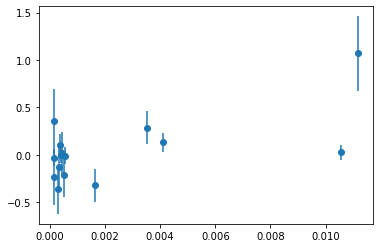

In [4]:

plt.scatter(x=dfpl.freq_phylo_, y=dfpl.deltaKd_mean)
plt.errorbar(x=dfpl.freq_phylo_, y=dfpl.deltaKd_mean, yerr=dfpl.deltaKd_std, ls='')


In [5]:
dfpl.to_csv("gisaid_fig1_data.csv")

In [6]:
## fig 2

def f(x, ichoice, im):
    a = "".join()

df2 = pd.read_csv("./Proportion_happen_same_time_N501_normalized.csv").rename({'Unnamed: 0': 'Mutation'}, axis=1)
dft = df.set_index("geno")
dfpl = pd.DataFrame()
kds = df.set_index("geno").log10Kd.to_dict()
errkds = df.set_index("geno").err_log10Kd.to_dict()
nbmuts, deltas, muts, keeps, deltas_err, sources, kdbackground = [], [], [], [], [], [], []
ichoice = 13
print(mutation_names[ichoice])
for im, m in tqdm(enumerate(mutation_names)):
    muts += [m]*(len(df))
    for s in df.geno:
        deltas += [-kds[s] + kds[s[:im] + '1' + s[im+1:]]
                   + kds[s[:ichoice] + '1' + s[ichoice+1:]] 
                   - kds["".join([a if ii!=ichoice and ii!= im else '1' for ii, a in enumerate(s)])]]
        deltas_err += [np.sqrt(errkds[s]**2 + errkds[s[:im] + '1' + s[im+1:]]**2)]
        kdbackground += [kds[s]]
        nbmuts += [s.count('1')]
        keeps += [s[im] != '1' and s[ichoice] != '1']
        sources += [s]

dfpl = pd.DataFrame()
dfpl["Mutation"] = muts
dfpl['deltaKdY-deltaKdN'] = deltas
dfpl['deltaKdY-deltaKdN'] = -dfpl['deltaKdY-deltaKdN']
dfpl[r'Number of mutations'] = nbmuts
dfpl[r'err_ΔKd'] = deltas_err
dfpl[r'source'] = sources
dfpl[r'kdbackground'] = kdbackground
dfpl[r'source_Kd'] = dfpl.source.map(kds)
dfpl = dfpl[keeps]

dfpl = dfpl.groupby(["Mutation"]).agg({'deltaKdY-deltaKdN': ['mean', 'std']}).reset_index()
dfpl["freq_phylo"] = dfpl.Mutation.map(df2.set_index("Mutation")['N501Y'])
dfpl.columns = ['_'.join(col).strip() for col in dfpl.columns.values]
dfpl = dfpl[dfpl.Mutation_ != 'N501Y'].copy()

N501Y


0it [00:00, ?it/s]

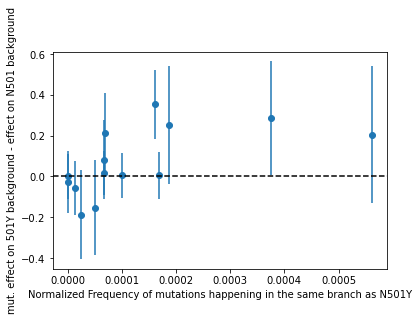

In [7]:

plt.scatter(x=dfpl.freq_phylo_, y=dfpl['deltaKdY-deltaKdN_mean'])
plt.errorbar(x=dfpl.freq_phylo_, y=dfpl['deltaKdY-deltaKdN_mean'], yerr=dfpl['deltaKdY-deltaKdN_std'], ls='')
plt.xlabel("Normalized Frequency of mutations happening in the same branch as N501Y")
plt.ylabel("mut. effect on 501Y background - effect on N501 background")
plt.axhline(ls='dashed', color='k')

In [8]:
dfpl.to_csv("gisaid_fig2_data.csv")